### Here we create HDF5 files using the NASA blue marble high-res images, for pix2pix translation with GANs.

Download the images.

In [3]:
%%bash
#wget https://eoimages.gsfc.nasa.gov/images/imagerecords/74000/74218/world.200412.3x21600x10800.jpg
mkdir data
mv world.200412.3x21600x10800.jpg data/

In [208]:
%%bash
wget https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73934/gebco_08_rev_elev_21600x10800.png
mv gebco_08_rev_elev_21600x10800.png data/

--2017-05-17 22:55:38--  https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73934/gebco_08_rev_elev_21600x10800.png
Resolving eoimages.gsfc.nasa.gov (eoimages.gsfc.nasa.gov)... 128.183.160.186
Connecting to eoimages.gsfc.nasa.gov (eoimages.gsfc.nasa.gov)|128.183.160.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18414843 (18M) [image/png]
Saving to: ‘gebco_08_rev_elev_21600x10800.png’

     0K .......... .......... .......... .......... ..........  0%  477K 38s
    50K .......... .......... .......... .......... ..........  0%  689K 32s
   100K .......... .......... .......... .......... ..........  0% 1.10M 26s
   150K .......... .......... .......... .......... ..........  1% 2.91M 21s
   200K .......... .......... .......... .......... ..........  1% 1.11M 20s
   250K .......... .......... .......... .......... ..........  1% 1.12M 19s
   300K .......... .......... .......... .......... ..........  1% 41.9M 17s
   350K .......... .......... .....

Code to extract chunks.

In [41]:
from skimage.io import imread
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
texture = imread("../data/world.200412.3x21600x10800.jpg")

/home/cbeckham/anaconda2/lib/python2.7/site-packages/PIL/Image.py:2274: DecompressionBombWarning: Image size (233280000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [3]:
texture.shape

(10800, 21600, 3)

In [4]:
heightmap = imread("../data/gebco_08_rev_elev_21600x10800.png")
heightmap.shape

(10800, 21600)

### Test thresholding code for heightmaps

0.790794372559


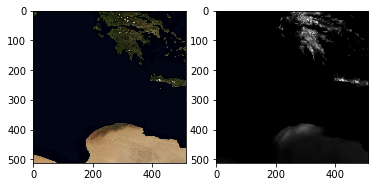

In [40]:
xoff, yoff = np.random.randint(0, heightmap.shape[1]), np.random.randint(0, heightmap.shape[0])
crp = heightmap[ yoff:yoff+512, xoff:xoff+512 ]
tx = texture[ yoff:yoff+512, xoff:xoff+512 ]
plt.subplot(1,2,1)
plt.imshow(tx)
plt.subplot(1,2,2)
plt.imshow(crp, cmap="gray")
print ((crp==0).sum()*1.0) / np.prod(crp.shape)

In [142]:
def comparator(heightmap_chunk, texture_chunk):
    """
    returns True if we should keep the chunk, otherwise
    False to discard it
    """
    # count how much black there is in the heightmap
    thresh = ((heightmap_chunk==0).sum()*1.0) / np.prod(heightmap_chunk.shape)
    # if more than 90% black, skip it
    if thresh > 0.9:
        return False
    return True

In [144]:
def get_chunks(img, img2, crop_size=256, stride=1, max_n=None, debug=False, dry_run=False):
    """
    img: texture map
    img2: height map
    
    """
    assert img.shape[0] == img2.shape[0] and img.shape[1] == img2.shape[1]
    ctr = 0
    is_done = False
    for y in range(0, img.shape[0], stride):
        print y
        for x in range(0, img.shape[1], stride):
            chunk = img[ y:y+crop_size, x:x+crop_size ] # texture
            chunk2 = img2[ y:y+crop_size, x:x+crop_size ][:,:,np.newaxis] # heightmap
            if chunk.shape != (crop_size, crop_size, 3):
                continue
            # if the comparator doesn't like the chunk,
            # discard it
            if not comparator(chunk2, chunk):
                continue
            if dry_run:
                yield None
            else:
                yield chunk, chunk2
                ctr += 1
            if max_n != None and ctr == max_n:
                return

Just do a dry run to see how many we have to save

In [145]:
t0 = time.time()
ctr = 0
for chunk in get_chunks(texture, heightmap, crop_size=512, stride=100, max_n=None):
    ctr += 1
    pass
print "time taken to process: %f sec" % (time.time()-t0)
print "number of patches detected: %i" % ctr

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
time taken to process: 17.467401 sec
number of patches detected: 10052


Ok now we can write an H5 file out

In [69]:
OUT_FILE = None

In [146]:
import h5py
#if f != None:
#    f.close()
f = h5py.File(OUT_FILE, 'w')
num_train = int(ctr*0.9)
num_valid = int(ctr*0.1)
f.create_dataset('xt', (num_train, 512, 512, 1), dtype='uint8')
f.create_dataset('yt', (num_train, 512, 512, 3), dtype='uint8')
f.create_dataset('xv', (num_valid, 512, 512, 1), dtype='uint8')
f.create_dataset('yv', (num_valid, 512, 512, 3), dtype='uint8')

<HDF5 dataset "heightmaps": shape (10052, 512, 512, 1), type "|u1">

In [147]:
idxs = [x for x in range(ctr)]
rnd_state = np.random.RandomState(0)
rnd_state.shuffle(idxs)

In [148]:
t0 = time.time()
ctr = 0
for chunk1, chunk2 in get_chunks(texture, heightmap, crop_size=512, stride=100, max_n=None):
    f['textures'][idxs[ctr]] = chunk1
    f['heightmaps'][idxs[ctr]] = chunk2
    ctr += 1
print time.time()-t0
print "number of patches detected:", ctr

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
128.088675976
number of patches detected: 10052


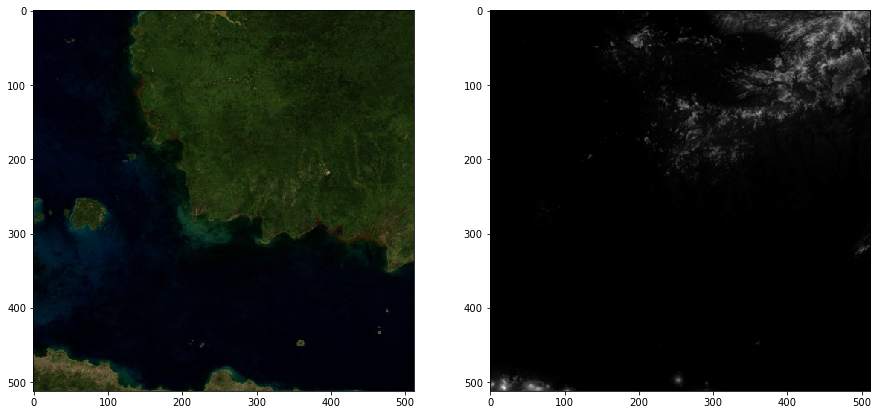

In [168]:
#good_value = 4660
#idx = np.random.randint(0, f['textures'].shape[0])
idx = 10000
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow( f['textures'][idx] ) #7700
plt.subplot(1,2,2)
plt.imshow( f['heightmaps'][idx][:,:,0],cmap="gray" ) #7700

In [185]:
f.close()

ValueError: Not a file id (Not a file id)

Crude comparator excluding images with too much water

In [170]:
%%bash
du -h /cuda4/storeSSD/cbeckham2/nasa/textures.h5

11G	/cuda4/storeSSD/cbeckham2/nasa/textures.h5


Better comparator excluding heightmaps with >90% black

In [171]:
%%bash
du -h /cuda4/storeSSD/cbeckham2/nasa/textures_v2.h5

9.9G	/cuda4/storeSSD/cbeckham2/nasa/textures_v2.h5


-----------

In [52]:
import h5py

f.close()

num_train = int(10052*0.9)
num_valid = int(10052*0.1)

f = h5py.File('/cuda4/storeSSD/cbeckham2/nasa/textures_v2_90-10.h5', 'w')
f.create_dataset('yt', (num_train, 512, 512, 3), dtype='uint8')
f.create_dataset('xt', (num_train, 512, 512, 1), dtype='uint8')
f.create_dataset('yv', (num_valid, 512, 512, 3), dtype='uint8')
f.create_dataset('xv', (num_valid, 512, 512, 1), dtype='uint8')

<HDF5 dataset "xv": shape (1005, 512, 512, 1), type "|u1">

In [70]:
g = h5py.File('/cuda4/storeSSD/cbeckham2/nasa/textures_v2.h5','r')

In [53]:
for k in range(num_train):
    f['xt'][k] = g['heightmaps'][k]
    f['yt'][k] = g['textures'][k]

In [54]:
for k in range(num_valid):
    f['xv'][k] = g['heightmaps'][num_valid+k]
    f['yv'][k] = g['textures'][num_valid+k]

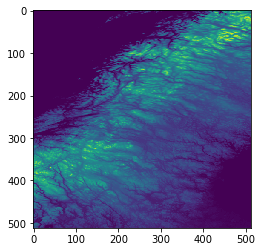

In [65]:
plt.imshow(f['xt'][-1][:,:,0])

In [66]:
f.close()

In [67]:
%%bash
du -h /cuda4/storeSSD/cbeckham2/nasa/textures_v2_90-10.h5

9.9G	/cuda4/storeSSD/cbeckham2/nasa/textures_v2_90-10.h5


-----------

Can we find the images that are all-green with a simple heuristic?

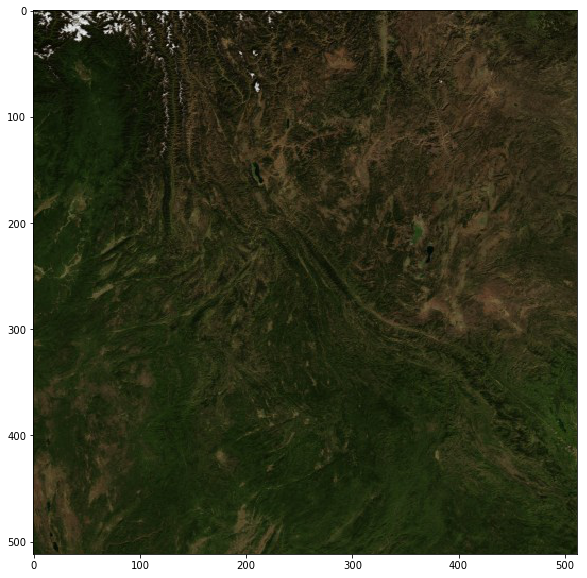

In [142]:
# the reference jungle image
plt.figure(figsize=(10,10))
some_img = g['textures'][4642][:]
plt.imshow(some_img)

In [ ]:
plt.figure(figsize=(10,10))
some_img = g['textures'][4642][:]
plt.imshow(some_img)

In [216]:
def get_idxs_close_to_img(some_img, db):
    """
    :some_img:
    :db: an H5 array
    :max_num:
    :returns: the computed MSEs, and the sorted indices
    """
    # find the mean rgb for the reference image
    ref_rgb = np.mean(some_img,axis=(0,1),keepdims=True)
    tmp = []
    for i in range(db.shape[0]):
        dist = np.sum((ref_rgb - np.mean(db[i],axis=(0,1),keepdims=True))**2)
        tmp.append(dist)    
    return tmp, np.argsort(tmp)

In [194]:
# let's create a test h5 with just green terrain
f1.close()
f1 = h5py.File('/cuda4/storeSSD/cbeckham2/nasa/textures_v2_green500.h5', 'w')
f1.create_dataset('yt', (500, 512, 512, 3), dtype='uint8')
f1.create_dataset('xt', (500, 512, 512, 1), dtype='uint8')
f1.create_dataset('yv', (500, 512, 512, 3), dtype='uint8')
f1.create_dataset('xv', (500, 512, 512, 1), dtype='uint8')
f1['xt'][0:500] = g['heightmaps'][ sorted(sorted_idxs.tolist()) ]
f1['yt'][0:500] = g['textures'][ sorted(sorted_idxs.tolist()) ]
f1['xv'][0:500] = f1['xt']
f1['yv'][0:500] = f1['yt']
f1.close()

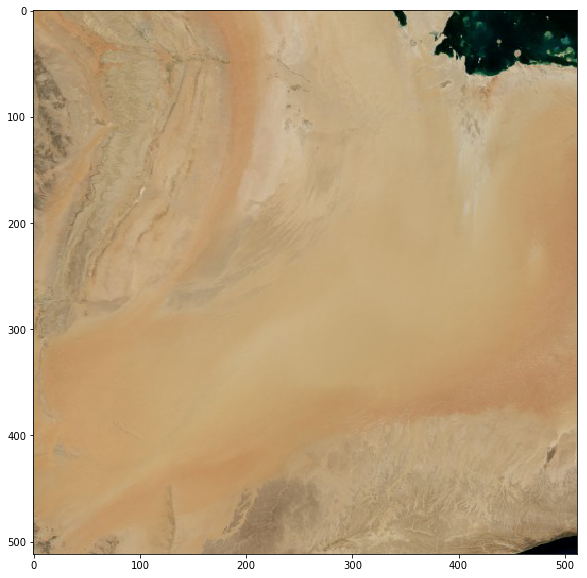

In [203]:
# the reference desert image
plt.figure(figsize=(10,10))
some_img = g['textures'][2132][:]
plt.imshow(some_img)

In [204]:
desert_mse, desert_idxs = get_idxs_close_to_img(some_img, g['textures'], max_num=500)

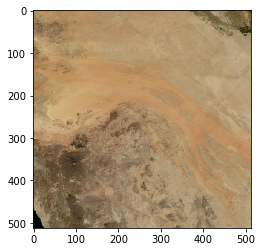

In [230]:
# up to 240 then it starts going to snow...
plt.imshow(g['textures'][desert_idxs[240]])

In [231]:
# let's create a test h5 with just green terrain
f2 = h5py.File('/cuda4/storeSSD/cbeckham2/nasa/textures_v2_brown500.h5', 'w')
n = 240
f2.create_dataset('yt', (n, 512, 512, 3), dtype='uint8')
f2.create_dataset('xt', (n, 512, 512, 1), dtype='uint8')
f2.create_dataset('yv', (n, 512, 512, 3), dtype='uint8')
f2.create_dataset('xv', (n, 512, 512, 1), dtype='uint8')
f2['xt'][0:n] = g['heightmaps'][ sorted(desert_idxs[0:240].tolist()) ]
f2['yt'][0:n] = g['textures'][ sorted(desert_idxs[0:240].tolist()) ]
f2['xv'][0:n] = f2['xt']
f2['yv'][0:n] = f2['yt']
f2.close()